In [1]:
! pip install pandas==1.1.0 matplotlib==3.5.0 numpy>=1.15.4 holidays>0.11 sklearn>1.0

# Time series analysis



In [2]:
# We first import some useful package for the data exploration
import pandas as pd
import numpy as np
import holidays
import datetime
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 16})

In [3]:
accounts = pd.read_csv('../data/accounts.csv', parse_dates=['update_date'], infer_datetime_format=True)
transactions = pd.read_csv('../data/transactions.csv', parse_dates=['date'], infer_datetime_format=True)

### Accounts

We check if there are any duplicates in the balances. We also raise an error if the same account has two different balances for the same day

In [4]:
print(accounts.info())

if len(accounts[accounts.duplicated()]) > 0:
    accounts = accounts.drop_duplicates()
    if len(accounts[accounts['id'].duplicated()]) > 0:
        raise Exception('Account(s) {} has two different balances associated to the same day'.format(accounts['id'].duplicated().to_list()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1254 entries, 0 to 1253
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           1254 non-null   int64         
 1   balance      1254 non-null   float64       
 2   update_date  1254 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 29.5 KB
None


The extraction of the balance is the same for all the accounts

In [5]:
#Same final update date
accounts['update_date'].unique()

array(['2021-07-02T00:00:00.000000000'], dtype='datetime64[ns]')

Points outside farther away than 5 std from the mean:
 [-98240.37, 216975.66, 76910.9, 150087.16, 62813.93, 131378.61]


count      1254.000000
mean       2495.186994
std       11853.402866
min      -98240.370000
25%           1.132500
50%          72.065000
75%        1083.257500
max      216975.660000
Name: balance, dtype: float64

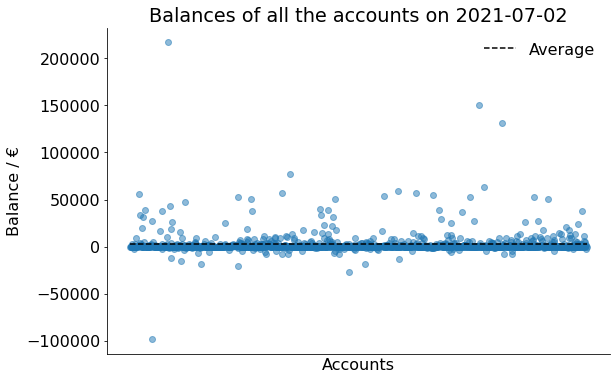

In [6]:
# don't know the data => use all of them even if -100000 seems a little weird

updatedate = str(accounts['update_date'].unique()[0]).split('T')[0]

fig, ax = plt.subplots(figsize=(9, 6))
ax.scatter(accounts['id'], accounts['balance'], alpha=0.5)
ax.set_title('Balances of all the accounts on {}'.format(updatedate))
ax.set_ylabel('Balance / €')
ax.set_xlabel('Accounts')
ax.set_xticks([])

ax.hlines(xmin=0, xmax=accounts['id'].max(), y=accounts['balance'].mean(), 
          color='k', linestyle='--', label='Average')
ax.legend(frameon=False)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

print('Points outside farther away than 5 std from the mean:\n', 
      accounts[abs(accounts['balance']-accounts['balance'].mean())>5*accounts['balance'].std()]['balance'].to_list())

accounts['balance'].describe()

There are six values very much outside the balance distribution. I am a little suspicious about the value -98240 since usually banks freeze an account before it goes so much down, but since I don't really know the source of the data I decide to keep all of the values.

# Transactions

We first check if there are accounts without transactions or viceversa.

In [7]:
print('Data between {} and {}\n'.format(transactions['date'].max(), transactions['date'].min()))
transactions.info()

Data between 2021-07-01 00:00:00 and 2018-01-02 00:00:00

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518229 entries, 0 to 518228
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   account_id  518229 non-null  int64         
 1   date        518229 non-null  datetime64[ns]
 2   amount      518229 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 11.9 MB


In [8]:

# No missing information on any account
set(transactions['account_id'].unique()) == set(accounts['id'].unique())

True

There are several duplicates. If we had the exact time of the transactions we could delete them without problems. Although, since we have only the day, the duplicates could be the results of:

1. An error on the extraction of the data.
2. Two or more transactions with the same value that happened the same day.


In [9]:
print('N duplicated lines: ', len(transactions) - len(transactions.drop_duplicates()))

id_dup = set(transactions[transactions.duplicated()]['account_id'].unique())
id_un = set(transactions['account_id'].unique()).difference(id_dup)
print('There are {} id without any duplicated row'.format(len(id_un)))


day_dup = set(transactions[transactions.duplicated()]['date'].unique())
day_un = set(transactions['date'].unique()).difference(day_dup)
print('There are {} days without any duplicated row'.format(len(day_un)))

if len(transactions[(transactions['account_id'].isin(id_un)) & (transactions['date'].isin(day_dup))])>0 and \
    len(transactions[(transactions['account_id'].isin(id_dup)) & (transactions['date'].isin(day_un))])>0:
    print('The presence of duplicated rows does not seems to be particularly related to day nor account id')

N duplicated lines:  28661
There are 231 id without any duplicated row
There are 311 days without any duplicated row
The presence of duplicated rows does not seems to be particularly related to day nor account id


Without any more information, and given the high number of duplicated rows (more than 28000), for the following I will suppose the duplicated rows are related to an error in their extraction and so I will delete them

In [10]:
# Assume duplicates are not interesting, 
# although they might be two different transactions with the same value happening the same day
transactions = transactions.drop_duplicates()

In [11]:
print('{:.1f}% of the transactions are negative'.format(100*len(transactions[transactions['amount']<0])
                                                        /len(transactions)))

79.7% of the transactions are negative


In [12]:
neg_tr_ac = transactions[transactions['amount']<0]['account_id'].unique()
n_acc_pos = transactions[(~transactions['account_id'].isin(neg_tr_ac))]['account_id'].nunique()
print('There are {} accounts with only positive transactions'.format(n_acc_pos))

There are 13 accounts with only positive transactions


On average, for each account, we have that if a transaction take place, other two follow the same day.

In [13]:
transactions.groupby(['account_id', 'date']).size().describe()

count    178344.000000
mean          2.745077
std           2.417142
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max         148.000000
dtype: float64

There are more than 10000 transactions with an amount equal to 0.0. It would be interesting to know if they are related to authorizations (and might then be a signal for a future transactions) or operations that were cancelled or refused or something else.


In [14]:
trans_per_ac = transactions.groupby('account_id')['amount'].describe().describe()
print('Each account has between {:.0f} and {:.0f} transactions ({:.0f} on average).\n'.format(trans_per_ac.loc['min', 'count'],
                                                                               trans_per_ac.loc['max', 'count'],
                                                                               trans_per_ac.loc['mean', 'count'])
      +'The average amount of the transaction per account is {:.2f}'.format(trans_per_ac.loc['mean', 'mean']))

Each account has between 1 and 3219 transactions (390 on average).
The average amount of the transaction per account is 26.10


# Data preparation

We start by selecting only the accounts older than 180 days

In [15]:
age = transactions.groupby(['account_id']).agg({'date':np.ptp})

transactions = transactions[transactions['account_id'].isin(age[age['date'].dt.days>=180].index.values)]
accounts = accounts[accounts['id'].isin(age[age['date'].dt.days>=180].index.values)]

We try to keep track of the transactions with an amount equal to 0 to try and use them during training, in the hypothesis they are related to authorizations.

We start calculating our target, and sum all the transactions in the same day.

In [16]:
# Order the dataframes
transactions = transactions.sort_values(by=['account_id', 'date'], ascending=[True, False]).reset_index(drop=True)
accounts = accounts.sort_values(by=['id'], ascending=True).reset_index(drop=True)

# We create a column to keep track of the zero amount transactions
transactions.loc[:, 'Zero_amount'] = (transactions['amount']==0).astype(int)

outgoing = transactions[transactions['amount']<0].groupby(['account_id', 'date'])['amount'].sum().rename('outgoing')
incoming = transactions[transactions['amount']>0].groupby(['account_id', 'date'])['amount'].sum().rename('incoming')

transactions = transactions.groupby(['account_id', 'date']).sum()\
                           .merge(outgoing, how='left', left_index=True, right_index=True)\
                           .merge(incoming, how='left', left_index=True, right_index=True)\
                           .fillna(0).reset_index()

For simplicity, as features I will use the 6 values resulting from the sum of the transactions in the last months.

Other approaches that uses the information from the single transaction as is, adding additional information on the day when it happened, might work better but they would be longer to implement.

I suppose the same model would describe well the outgoing, independently from the account. I have then several possible way to split my data and define the test sample. To have an idea on how well the model works on different 

In [17]:
# Calculate the sum of the transactions on 30 days intervals
transactions = transactions.set_index('date')\
                           .groupby('account_id')\
                           .resample('30D').sum()\
                           .drop('account_id', axis=1).reset_index()


# Find where the accounts change and set the latest account balance,
# Assuming the balance is always more recent than all the transactions
transactions.loc[transactions[transactions['account_id'].diff() != 0].index, 'balance'] = accounts['balance']

# Where the balance is null, initialize the balance value to the inverse of the transaction
transactions.loc[transactions['balance'].isnull(), 'balance'] = -transactions['amount'].shift()
# then use a cumulative sum divided by account to find the value of the balance after each operation
transactions.loc[:, 'balance'] = transactions.groupby('account_id')['balance'].cumsum()

# Subtract balance and amount to get the balance before the transaction
transactions.loc[:, 'balance_start'] = transactions['balance']-transactions['amount']

In [18]:
# the year and month at the beginning of the 30 days
transactions.loc[:, 'month'] = transactions['date'].dt.month
transactions.loc[:, 'year'] = transactions['date'].dt.year

# we count how many working days there were in the 30 days period
fr_hol = holidays.France(years=transactions['date'].dt.year).keys()
transactions.loc[:, 'work'] = transactions['date'].apply(lambda x: np.busday_count(x.date(), 
                                                                                   x.date() + datetime.timedelta(30),
                                                                                   holidays=[np.datetime64(x) for x in fr_hol]))


In [19]:
def create_feat(df, win=6):
    # Inspired by
    # https://stackoverflow.com/questions/47482009/pandas-rolling-window-to-return-an-array
    as_strided = np.lib.stride_tricks.as_strided
    
    cols = ['account_id', 'amount', 'Zero_amount', 'outgoing', 'incoming', 
            'balance', 'balance_start', 'month', 'year', 'work']
    res = pd.DataFrame(columns=cols)
    for i in cols:
        v = as_strided(df[i], (len(df[i]) - (win - 1), win), (df[i].values.strides * 2))
        res.loc[:, i] = pd.Series(v.tolist(), index=range(0, len(v)))
    return res


features = create_feat(transactions, win=6)
# Cancel series using spurious accounts id
features = features.loc[transactions[transactions['account_id']==transactions['account_id'].shift(-6)].index]
for i in features.columns:
    if i=='account_id':
        features.loc[:, 'account_id'] = features['account_id'].map(lambda x: x[0])
        continue
    colnames = ['{}_{}'.format(i,j) for j in range(6,0,-1)]
    features[colnames] = pd.DataFrame(features[i].values.tolist(), index= features.index)
    features = features.drop(i, axis=1)


labels = transactions.shift(-6).loc[features.index]['outgoing']

# Training

In [20]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_validate, GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor

In [21]:
X_train, X_test, y_train, y_test = train_test_split(features.drop('account_id', axis=1), labels,
                                                    test_size=0.2, random_state=42)

tscv = TimeSeriesSplit(n_splits=5,gap=0)

### Naive
A first very naive approach, to use as baseline: just taking the average of the last 6 outgoing.

In [22]:
from sklearn.metrics import r2_score, mean_absolute_error


cols = [x for x in X_train.columns if 'outgoing_' in x]

y_pred = X_train.loc[:, cols].mean(axis=1)

r2 = r2_score(y_train, y_pred)

mae = mean_absolute_error(y_train, y_pred)

print('Mean Absolute Error: {}\nR2: {}'.format(mae, r2))

Mean Absolute Error: 3089.3938137330256
R2: 0.20953110260929952


### ElasticNet

In [29]:
'''
# Commented out to avouid re-run every time
en = ElasticNet(random_state=42)

enpipe = Pipeline([('scaler', StandardScaler()), ('elastic', en)])

param_grid = {'elastic__alpha': [1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0],
             'elastic__l1_ratio': np.arange(0, 1, 0.1)}

# define search
search = GridSearchCV(enpipe, param_grid, scoring='neg_mean_absolute_error', cv=tscv, n_jobs=-1)



results = search.fit(X_train, y_train)
# summarize
print('MAE: {%.3f}'.format(results.best_score_))
print('Config: {}'.format(results.best_params_))

# MAE: -2955.613
# Config: {'elastic__alpha': 1.0, 'elastic__l1_ratio': 0.8}
''';

In [24]:
enbest = Pipeline([('scaler', StandardScaler()),
                   ('elastic', ElasticNet(random_state=42, alpha=1.0, l1_ratio=0.8))])

enbest.fit(X_train, y_train)

cv_results = cross_validate(
        enbest,
        X_train,
        y_train,
        cv=tscv,
        scoring=["neg_mean_absolute_error", "r2"],
    )
mae = -cv_results["test_neg_mean_absolute_error"]
r2 = cv_results["test_r2"]
print('Mean Absolute Error:     {:.3f} +/- {:.3f}\n'.format(mae.mean(), mae.std())
      + 'R2: {:.3f} +/- {:.3f}'.format(r2.mean(), r2.std()))

Mean Absolute Error:     2955.613 +/- 128.629
R2: 0.280 +/- 0.288


### Random Forest

In [30]:
'''# Commented out to avouid re-run every time
rf = RandomForestRegressor(n_jobs=-1, bootstrap=True)

enpipe = Pipeline([('scaler', StandardScaler()), ('RanFor', rf)])

# Small parameter grid to save time
param_grid = {'RanFor__max_depth': [10, 50, 100],  'RanFor__max_features': ['auto', 'sqrt', 6],
              'RanFor__n_estimators': [100, 200]}

# define search
search = GridSearchCV(enpipe, param_grid, scoring='neg_mean_absolute_error', cv=tscv, n_jobs=-1)



results = search.fit(X_train, y_train)
# summarize
print('MAE: {:.3f}'.format(results.best_score_))
print('Config: {}'.format(results.best_params_))
''';

In [26]:
enrf = Pipeline([('scaler', StandardScaler()),
                 ('RanFor', RandomForestRegressor(n_jobs=-1, bootstrap=True, 
                                                   max_depth=50, max_features=6, n_estimators=200))])

enrf.fit(X_train, y_train)

cv_results = cross_validate(
        enrf,
        X_train,
        y_train,
        cv=tscv,
        scoring=["neg_mean_absolute_error", "r2"],
    )
mae = -cv_results["test_neg_mean_absolute_error"]
r2 = cv_results["test_r2"]
print('Mean Absolute Error:     {:.3f} +/- {:.3f}\n'.format(mae.mean(), mae.std())
      + 'R2: {:.3f} +/- {:.3f}'.format(r2.mean(), r2.std()))

Mean Absolute Error:     2897.250 +/- 123.596
R2: 0.296 +/- 0.091


The models did not really improve the naive result. For the sake of the exercise, I will take the RandomForest which gave slightly best results, and I will deploy it on the API. In a real situation I would test more models, try to play a little with the features as well (check for correlations, a more thorough study of feature importance than the following one, computation of new features, use more than 6 months if the data are available, etc...)

In [27]:
from joblib import dump
#dump(enrf, 'rf_pipeline.joblib') 

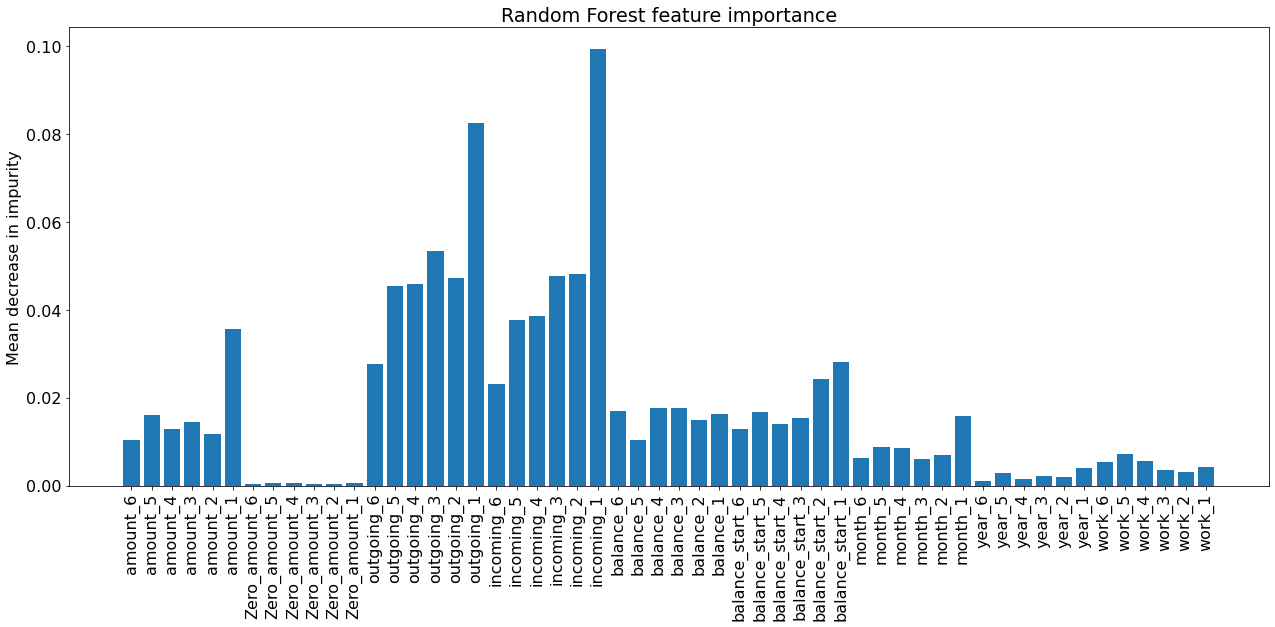

In [28]:


forest_importances = pd.Series(enrf['RanFor'].feature_importances_, index=X_train.columns)

fig, ax = plt.subplots(figsize=(18,9))
ax.bar(range(0, len(X_train.columns)), enrf['RanFor'].feature_importances_)
#forest_importances.plot.bar(ax=ax)
ax.set_ylabel("Mean decrease in impurity")
ax.set_xticks(range(0, len(X_train.columns)))
ax.set_xticklabels(X_train.columns, rotation=90)
ax.set_title('Random Forest feature importance')

fig.tight_layout()


The most important feature are the history of total incoming and outgoing transactions (especially the last month).

Apparently my feeling about the zero amount transactions was wrong...